# **Project Name**    - Shopper Spectrum: Product Recommendation &  Segmentation App





# **Project Summary -**
The Shopper Spectrum project is a dual-purpose, AI-powered e-commerce application designed to improve user engagement and business insights through two core modules: Product Recommendation and Customer Segmentation. Built using Python and Streamlit, the app provides an intuitive interface that supports both real-time recommendations and customer behavior analysis.

The Product Recommendation Module allows users to input the name of a product and receive five similar product suggestions. This is implemented using item-based collaborative filtering with cosine similarity, applied on a customer-product purchase matrix. This feature helps businesses improve cross-selling, guide user navigation, and enhance the overall shopping experience by suggesting relevant alternatives or complements to products.

The Customer Segmentation Module applies RFM (Recency, Frequency, Monetary) analysis to categorize customers based on their purchasing behavior. After calculating RFM values from transaction data, customers are grouped into segments using KMeans clustering. Segment labels like “High-Value,” “Regular,” “Occasional,” and “At-Risk” provide insights into user loyalty and spending patterns. This information can be used by marketing teams to tailor promotions and improve customer retention strategies.

Technologies used include Pandas, NumPy, scikit-learn for modeling and similarity calculations, and Streamlit for building a responsive UI. The project emphasizes both functionality and user experience, making it suitable for real-world retail applications where understanding customer behavior and boosting product visibility are key priorities.

# **GitHub Link -**
https://github.com/GayatriKhairnar06/Shopper-Spectrum

# **Problem Statement**
In the rapidly growing e-commerce industry, businesses face challenges in understanding customer preferences and providing personalized shopping experiences. With vast product catalogs and diverse customer behaviors, users often struggle to find relevant products, while businesses lack insights to effectively segment and target their customers. This results in missed opportunities for upselling, reduced customer satisfaction, and ineffective marketing strategies. There is a need for an intelligent system that can recommend similar products to users and segment customers based on their purchasing behavior to drive engagement and improve business decisions.

#### **Business Objective**
The primary objective of this project is to enhance the customer shopping experience and support business growth by developing a unified system that provides personalized product recommendations and meaningful customer segmentation. By leveraging item-based collaborative filtering, the system will recommend similar products based on customer purchase history, improving cross-selling and product discovery. Simultaneously, RFM (Recency, Frequency, Monetary) analysis will be used to segment customers into distinct behavioral groups, allowing businesses to tailor their marketing strategies, improve customer retention, and optimize resource allocation. This dual approach aims to drive customer satisfaction, boost sales, and enable data-driven decision-making.

# Code
## Step 1: Import Libraries

In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score




## Step 2: Load Dataset & Data Preprocessing


In [ ]:
# Load Dataset
df = pd.read_csv("/content/online_retail.csv", encoding='ISO-8859-1')
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"], errors='coerce')

# Basic Preprocessing
df.dropna(subset=["CustomerID"], inplace=True)  # Remove rows without CustomerID
df = df[~df["InvoiceNo"].astype(str).str.startswith("C")]  # Remove canceled invoices starting with C
df = df[(df["Quantity"] > 0) & (df["UnitPrice"] > 0)]  # Remove negative or zero values


##Step 3:Exploratory Data Analysis

<Axes: title={'center': 'Number of Transactions per Country'}, xlabel='Country'>

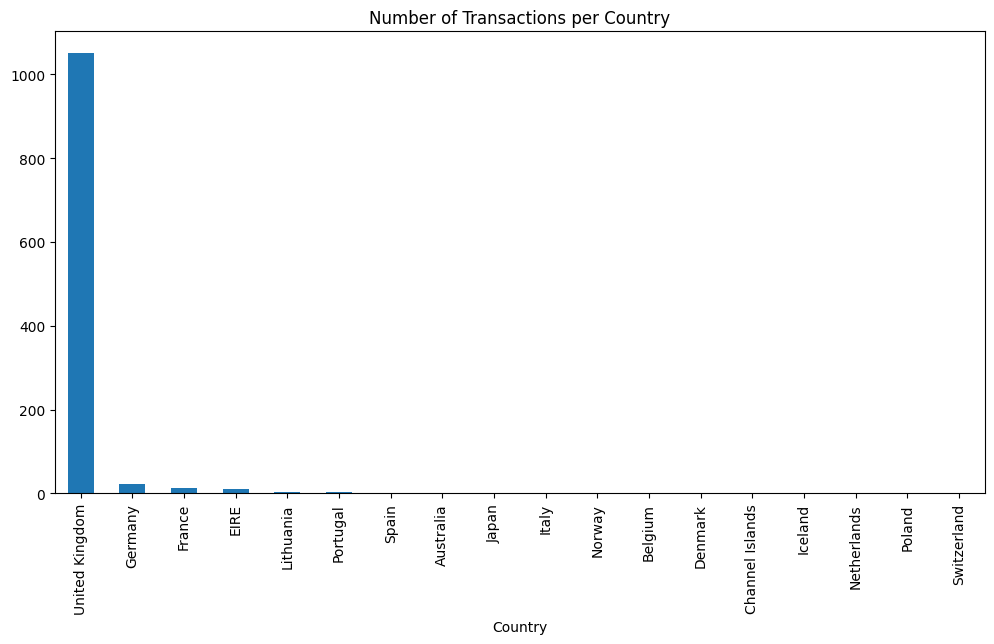

In [ ]:
# Transaction volume by country (excluding United Kingdom if needed)
original_df = pd.read_csv("/content/online_retail.csv", encoding='ISO-8859-1')
country_df = original_df.copy() # Create a copy of the original dataframe
country_orders = country_df.groupby('Country')['InvoiceNo'].nunique().sort_values(ascending=False)
country_orders.plot(kind='bar', figsize=(12, 6), title="Number of Transactions per Country")

<Axes: title={'center': 'Top-Selling Products (by Quantity)'}, xlabel='Description'>

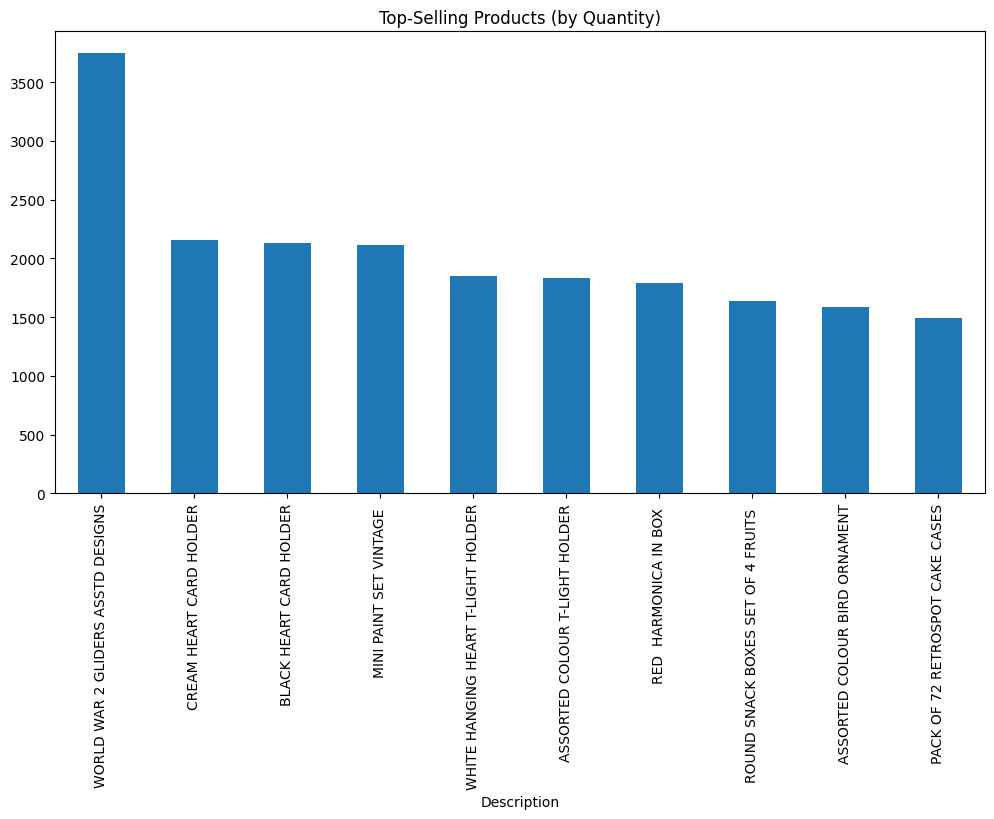

In [ ]:
#Identify top selling products
top_products = df.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10)
top_products.plot(kind='bar', figsize=(12, 6), title='Top-Selling Products (by Quantity)')

<Axes: title={'center': 'Purchase Trends Over Time (Daily Revenue)'}, xlabel='InvoiceDate'>

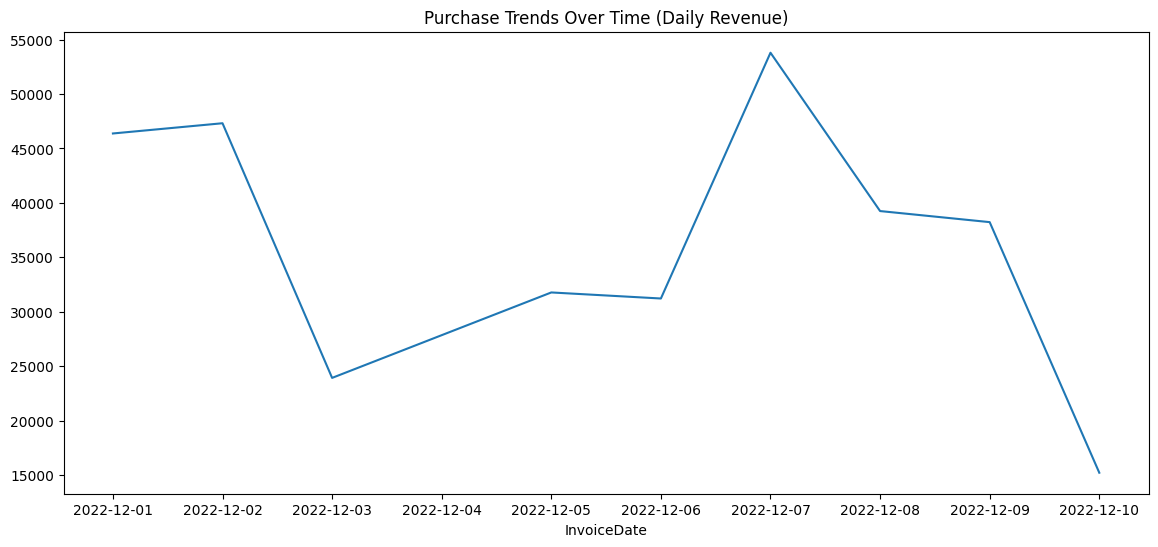

In [ ]:
#visualize purchase trends over time
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['TotalAmount'] = df['Quantity'] * df['UnitPrice']

# Daily revenue
daily_sales = df.groupby(df['InvoiceDate'].dt.date)['TotalAmount'].sum()
daily_sales.plot(figsize=(14, 6), title='Purchase Trends Over Time (Daily Revenue)')

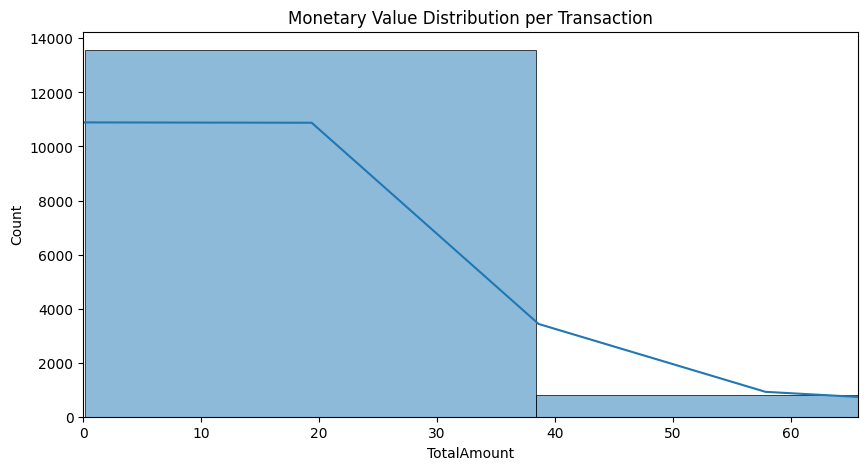

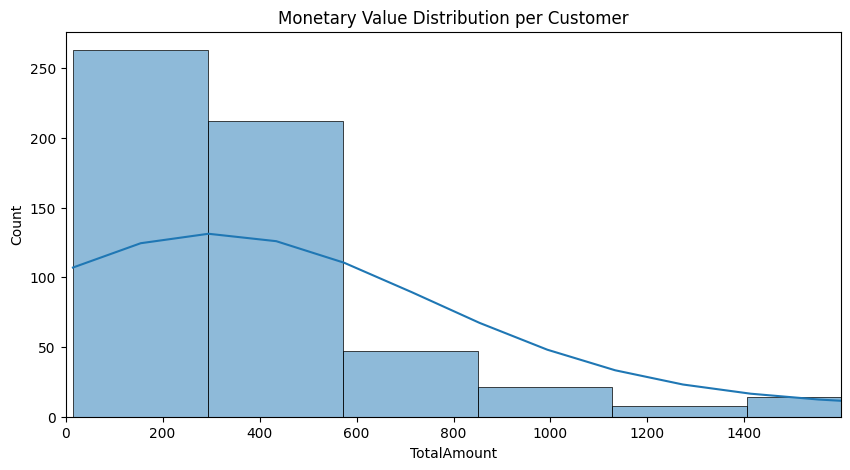

In [ ]:
#Inspect Monetary Distribution per Transaction and Customer
# Distribution per transaction
plt.figure(figsize=(10,5))
sns.histplot(df['TotalAmount'], bins=100, kde=True)
plt.title('Monetary Value Distribution per Transaction')
plt.xlim(0, df['TotalAmount'].quantile(0.95))  # Zoom to 95th percentile
plt.show()

# Distribution per customer
customer_monetary = df.groupby('CustomerID')['TotalAmount'].sum()
plt.figure(figsize=(10,5))
sns.histplot(customer_monetary, bins=100, kde=True)
plt.title('Monetary Value Distribution per Customer')
plt.xlim(0, customer_monetary.quantile(0.95))
plt.show()


##Step 4 :Clustering Methodology:


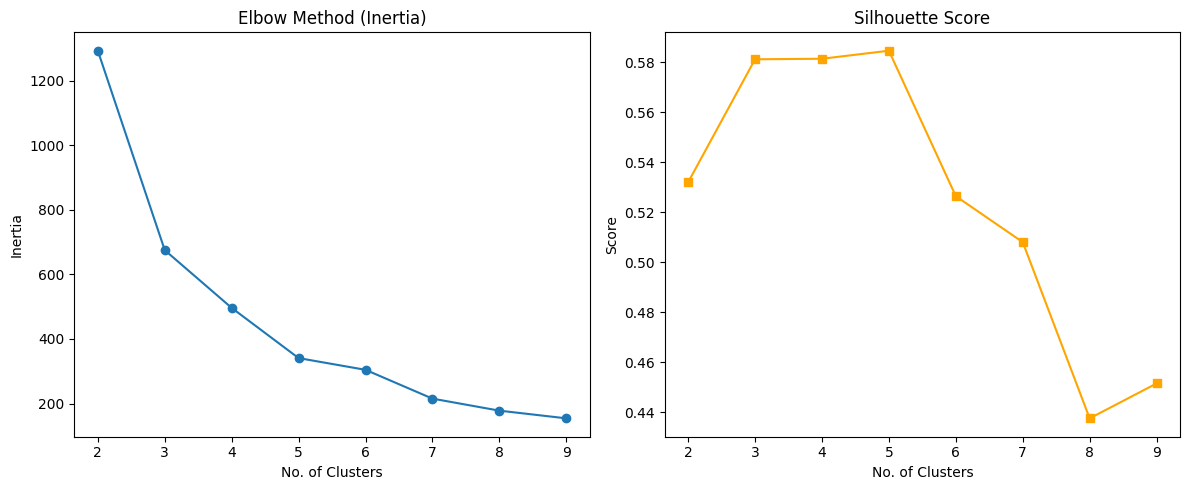


📊 Cluster Summary:
         Recency  Frequency  Monetary  Count
Cluster                                     
0            8.2        1.1     383.9    198
1            2.9        1.3     496.5    386
2            1.2       10.5   13509.0      4
3            8.0       34.0    5391.2      1

✅ Final segmented RFM saved as: rfm_segmented.csv


In [ ]:
# RFM Feature Engineering
snapshot_date = df["InvoiceDate"].max() + pd.Timedelta(days=1)

rfm = df.groupby("CustomerID").agg({
    "InvoiceDate": lambda x: (snapshot_date - x.max()).days,  # Recency
    "InvoiceNo": "nunique",                                   # Frequency
    "Quantity": lambda x: (x * df.loc[x.index, "UnitPrice"]).sum()  # Monetary
}).reset_index()

rfm.columns = ["CustomerID", "Recency", "Frequency", "Monetary"]

# Standardize RFM Features
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[["Recency", "Frequency", "Monetary"]])

# Optimal Clusters (Elbow Method)
inertia = []
silhouette = []

for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(rfm_scaled, kmeans.labels_))

# Plot Elbow and Silhouette Scores
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(2, 10), inertia, marker='o')
plt.title('Elbow Method (Inertia)')
plt.xlabel('No. of Clusters')
plt.ylabel('Inertia')

plt.subplot(1, 2, 2)
plt.plot(range(2, 10), silhouette, marker='s', color='orange')
plt.title('Silhouette Score')
plt.xlabel('No. of Clusters')
plt.ylabel('Score')

plt.tight_layout()
plt.show()

# Apply KMeans with optimal K (choose k from graph)
k_optimal = 4  # Example based on elbow/silhouette
kmeans = KMeans(n_clusters=k_optimal, random_state=42)
rfm["Cluster"] = kmeans.fit_predict(rfm_scaled)

# Interpret Clusters
cluster_summary = rfm.groupby("Cluster").agg({
    "Recency": "mean",
    "Frequency": "mean",
    "Monetary": "mean",
    "CustomerID": "count"
}).rename(columns={"CustomerID": "Count"}).round(1)

print("\n📊 Cluster Summary:")
print(cluster_summary)

# Optional: Map segment labels
def label_cluster(row):
    if row["Recency"] <= 30 and row["Frequency"] >= 10 and row["Monetary"] >= 300:
        return "High-Value"
    elif row["Recency"] <= 60 and row["Frequency"] >= 5:
        return "Regular"
    elif row["Recency"] > 120:
        return "At-Risk"
    else:
        return "Occasional"

rfm["Segment"] = rfm.apply(label_cluster, axis=1)

# Save labeled output
rfm.to_csv("rfm_segmented.csv", index=False)
print("\n✅ Final segmented RFM saved as: rfm_segmented.csv")

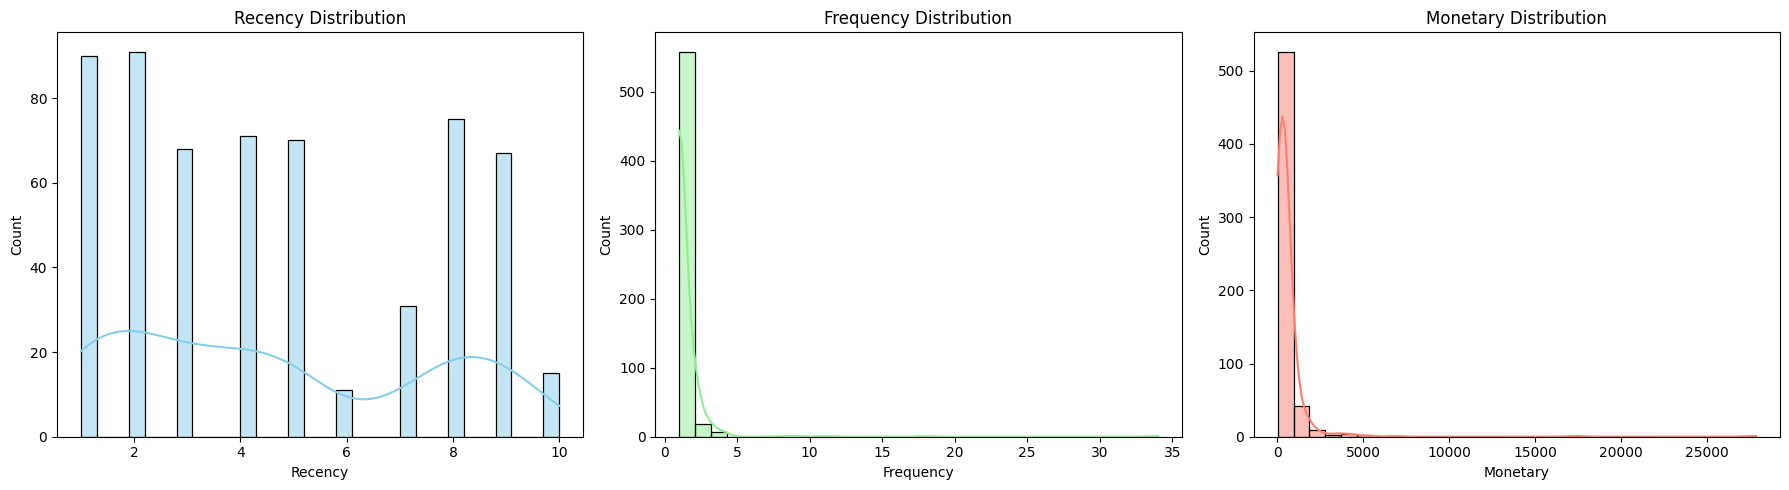

In [ ]:
#RFM Distributions
rfm_df = pd.read_csv('rfm_segmented.csv')  # Already available

# Distribution plots
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

sns.histplot(rfm_df['Recency'], bins=30, ax=ax[0], kde=True, color='skyblue')
ax[0].set_title('Recency Distribution')

sns.histplot(rfm_df['Frequency'], bins=30, ax=ax[1], kde=True, color='lightgreen')
ax[1].set_title('Frequency Distribution')

sns.histplot(rfm_df['Monetary'], bins=30, ax=ax[2], kde=True, color='salmon')
ax[2].set_title('Monetary Distribution')

plt.tight_layout()
plt.show()


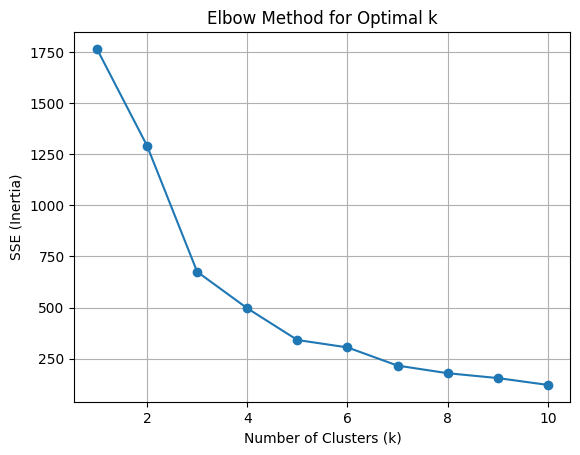

In [ ]:
#Elbow Curve for Cluster Selection
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_df[['Recency', 'Frequency', 'Monetary']])
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    sse.append(kmeans.inertia_)

plt.plot(range(1, 11), sse, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('SSE (Inertia)')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()


In [ ]:
#Customer Cluster Profiles (after applying KMeans)
# Assuming k=4 (or your chosen k)
kmeans = KMeans(n_clusters=4, random_state=42)
rfm_df['Cluster'] = kmeans.fit_predict(rfm_scaled)

# Cluster stats
cluster_profiles = rfm_df.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'CustomerID': 'count'
}).rename(columns={'CustomerID': 'Count'}).reset_index()

print(cluster_profiles)


   Cluster   Recency  Frequency      Monetary  Count
0        0  8.222222   1.131313    383.901566    198
1        1  2.862694   1.310881    496.497591    386
2        2  1.250000  10.500000  13509.020000      4
3        3  8.000000  34.000000   5391.210000      1


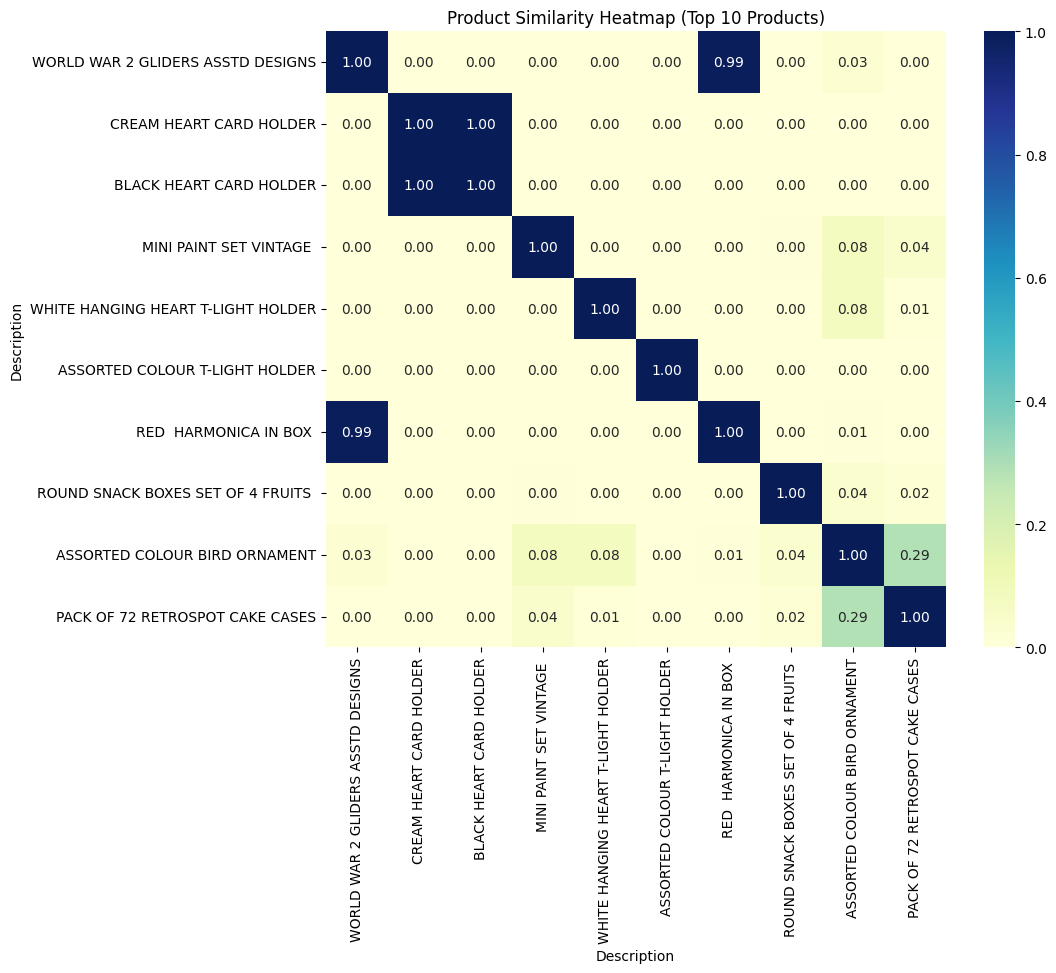

In [ ]:
#Product Recommendation Heatmap / Similarity Matrix
# Pivot table of customers and products
basket = df.pivot_table(index='CustomerID', columns='Description', values='Quantity', fill_value=0)

# Cosine similarity
from sklearn.metrics.pairwise import cosine_similarity

product_similarity = cosine_similarity(basket.T)
product_similarity_df = pd.DataFrame(product_similarity, index=basket.columns, columns=basket.columns)

# Heatmap of top products
top_items = top_products.index[:10]
plt.figure(figsize=(10, 8))
sns.heatmap(product_similarity_df.loc[top_items, top_items], cmap="YlGnBu", annot=True, fmt=".2f")
plt.title("Product Similarity Heatmap (Top 10 Products)")
plt.show()


##Step 4 :Clustering Methodology:


In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
df = pd.read_csv("rfm_segmented.csv")

# Just in case: drop old cluster column
if 'Cluster' in df.columns:
    df = df.drop(columns=['Cluster'])

# Select features and scale them
rfm = df[['Recency', 'Frequency', 'Monetary']]
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)

# Apply KMeans with k=4
kmeans = KMeans(n_clusters=4, random_state=42)
df['Cluster'] = kmeans.fit_predict(rfm_scaled)

# Check clustering result
df['Cluster'].value_counts().sort_index()

# Save the updated file if needed
df.to_csv("rfm_with_clusters.csv", index=False)


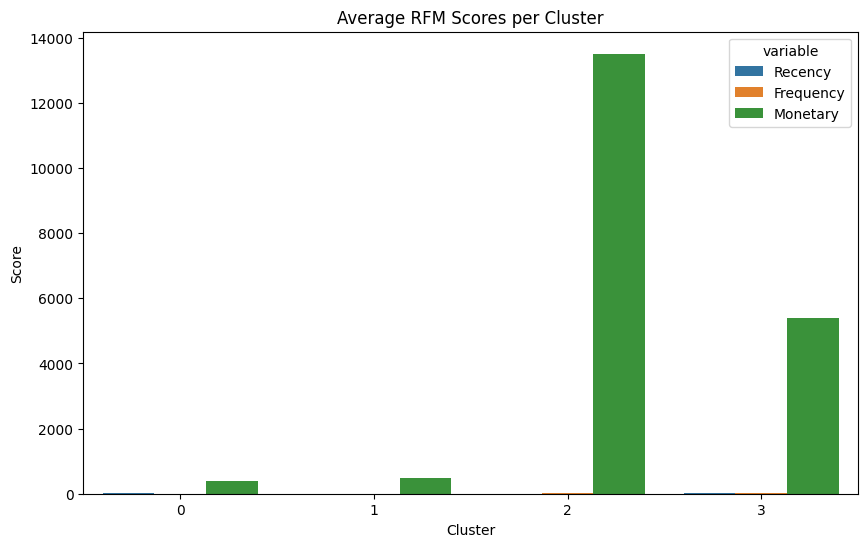

In [ ]:
# Group by Cluster to see average RFM per group
cluster_profiles = df.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean().reset_index()

# Plot RFM averages for each cluster
plt.figure(figsize=(10, 6))
sns.barplot(data=cluster_profiles.melt(id_vars="Cluster"), x='Cluster', y='value', hue='variable')
plt.title("Average RFM Scores per Cluster")
plt.ylabel("Score")
plt.show()


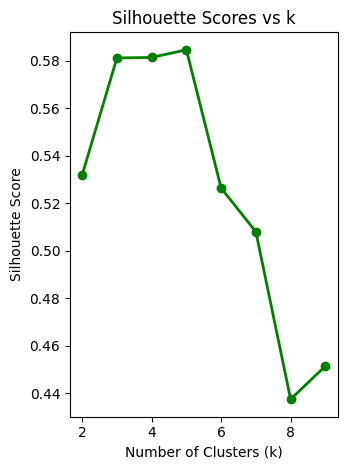

In [ ]:
# Plot Silhouette Scores
plt.subplot(1, 2, 2)
plt.plot(range(2,10), silhouette, 'go-', linewidth=2)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores vs k')

plt.tight_layout()
plt.show()

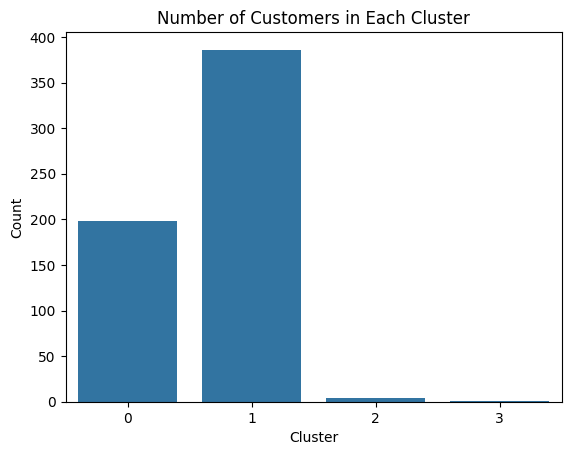

In [ ]:
sns.countplot(data=df, x='Cluster')
plt.title("Number of Customers in Each Cluster")
plt.xlabel("Cluster")
plt.ylabel("Count")
plt.show()



In [ ]:
print(df.columns)

Index(['CustomerID', 'Recency', 'Frequency', 'Monetary', 'Segment', 'Cluster'], dtype='object')


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# Create a basket matrix: rows = Customers, columns = Products (StockCode), values = Quantity
basket = original_df.groupby(['CustomerID', 'StockCode'])['Quantity'].sum().unstack().fillna(0)

# Optional: Binarize the data (just for similarity, not frequency-based)
basket_binary = basket.applymap(lambda x: 1 if x > 0 else 0)

/tmp/ipython-input-923946559.py:7: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  basket_binary = basket.applymap(lambda x: 1 if x > 0 else 0)


In [ ]:
# Transpose the matrix to get Product-Product similarity
product_similarity = cosine_similarity(basket_binary.T)

# Create a DataFrame for easy lookup
product_similarity_df = pd.DataFrame(product_similarity,index=basket_binary.columns,columns=basket_binary.columns)


In [ ]:
def recommend_similar_products(stock_code, top_n=5):
    if stock_code not in product_similarity_df.columns:
        print("Product not found in dataset.")
        return []

    # Sort products by similarity (excluding itself)
    similar_scores = product_similarity_df[stock_code].sort_values(ascending=False)
    top_similar = similar_scores.iloc[1:top_n+1]

    return top_similar


In [ ]:
def get_stockcode_from_description(description):
    matched = original_df[original_df['Description'].str.lower() == description.lower()]
    if not matched.empty:
        return matched['StockCode'].iloc[0]
    else:
        print("Product description not found.")
        return None

In [ ]:
# User inputs product name
product_name = "WHITE HANGING HEART T-LIGHT HOLDER"
stock_code = get_stockcode_from_description(product_name)

if stock_code:
    recommendations = recommend_similar_products(stock_code)
    print("Top 5 similar products:\n", recommendations)


Top 5 similar products:
 StockCode
21733    0.408903
22804    0.324797
82482    0.309435
22470    0.308880
22469    0.266760
Name: 85123A, dtype: float64
